In [1]:
using GeoJSON
using DataFrames
using Glob
using Distances
using PyPlot
using BenchmarkTools
const plt = PyPlot

PyPlot

## Coordinates of the summits

In [2]:
summits = Dict("tenerife"=> (28.27276, -16.64236),
               "grancanaria"=> (27.96085, -15.57120),
                "lapalma"=>(28.75448, -17.88511),
                "elhierro"=> (27.72919, -18.04044), 
                "lagomera"=> (28.10975, -17.24834),
                "fuerteventura"=> (28.10182, -14.35552),
                "lanzarote"=> (29.11927, -13.52098)
            )

Dict{String, Tuple{Float64, Float64}} with 7 entries:
  "elhierro"      => (27.7292, -18.0404)
  "fuerteventura" => (28.1018, -14.3555)
  "tenerife"      => (28.2728, -16.6424)
  "lagomera"      => (28.1097, -17.2483)
  "lapalma"       => (28.7545, -17.8851)
  "grancanaria"   => (27.9609, -15.5712)
  "lanzarote"     => (29.1193, -13.521)

### Files and directories

In [3]:
datadir = "../Data/Coastline/"
# datadir = "../../../../data/Coastline/"
datafilelist = Glob.glob(joinpath(datadir, "*json"))
nfiles = length(datafilelist)

distancefile = "../Data/distance_islands.txt"
nfiles

7

## Functions to read

In [4]:
function read_coords(geojsonfile::String)
    jsonbytes = read(geojsonfile)
    fc = GeoJSON.read(jsonbytes)
    contour = fc[1].geometry[1][1]
    
    # Count number of points and allocate
    npoints = length(contour)
    lon = Vector{Float32}(undef, npoints)
    lat = Vector{Float32}(undef, npoints)
    
    # Fill vectors
    for (iii, cc) in enumerate(contour)
        lon[iii] = cc[1]
        lat[iii] = cc[2]
    end
    
    return lon::Vector{Float32}, lat::Vector{Float32}, contour::Vector{Tuple{Float32, Float32}}
end

read_coords (generic function with 1 method)

In [5]:
function read_largest_contour(datafile::String)
    jsonbytes = read(datafile)
    fc = GeoJSON.read(jsonbytes)
    island = fc[1].geometry
    nislands = length(island)
    @debug("nislands = $(nislands)")
    local islandcontour
    maxpoints = 0
    
    for iii in 1:nislands
        
        npoints = length(island[iii])
        @debug(npoints)
        if npoints > 1
            coast = vcat(island[iii][1], island[iii][2])
        else
            coast = island[iii][1]
        end
        
        @debug("length coast = $(length(coast))")
        @debug("maxpoints = $(maxpoints)")
        if length(coast) > maxpoints
            maxpoints = length(coast)
            islandcontour = copy(coast)
        end
            
    end
    
    # Count number of points and allocate
    lon = Vector{Float32}(undef, maxpoints)
    lat = Vector{Float32}(undef, maxpoints)
    
    # Fill vectors
    for (iii, cc) in enumerate(islandcontour)
        lon[iii] = cc[1]
        lat[iii] = cc[2]
    end
    
    return lon::Vector{Float32}, lat::Vector{Float32}, islandcontour::Vector{Tuple{Float32, Float32}} 
        
end

read_largest_contour (generic function with 1 method)

In [12]:
function compute_min_dist(contour1::Vector{Tuple{Float32, Float32}}, contour2::Vector{Tuple{Float32, Float32}})
    local npoints1 = length(contour1)
    local npoints2 = length(contour2)
    
    # allocate
    distmatrix = Array{Float32}(undef, npoints1, npoints2)
    
    # reverse coordinates
    contour1 = reverse.(contour1)
    contour2 = reverse.(contour2)
    
    Threads.@threads for (ii1,ii2) in collect(Iterators.product(1:npoints1,1:npoints2))
        distmatrix[ii1, ii2] = haversine(contour1[ii1], contour2[ii2])
    end
    
    dminindex = argmin(distmatrix)
    closestpoint1 = contour1[dminindex[1]]
    closestpoint2 = contour2[dminindex[2]]
    
    return closestpoint1, closestpoint2, minimum(distmatrix) / 1000.

end

compute_min_dist (generic function with 1 method)

In [11]:
lon, lat, cc = read_largest_contour(joinpath(datadir, "grancanaria.geojson"));
lon2, lat2, cc2 = read_largest_contour(joinpath(datadir, "tenerife.geojson"));

@info(length(lon) * length(lon2));

[ Info: 24322402


In [13]:
function compute_min_dist_vec(contour1::Vector{Tuple{Float32, Float32}}, contour2::Vector{Tuple{Float32, Float32}})
    local npoints1 = length(contour1)
    local npoints2 = length(contour2)
    
    # allocate
    distvector = Vector{Float32}(undef, npoints1)
    aminvect = Vector{Int64}(undef, npoints1)
    
    # reverse coordinates
    contour1 = reverse.(contour1)
    contour2 = reverse.(contour2)
    
    Threads.@threads for ii1 in 1:npoints1
        distvector[ii1] = minimum(haversine.([contour1[ii1]], contour2))
        aminvect[ii1] = argmin(haversine.([contour1[ii1]], contour2))
    end
    
    indmin = argmin(distvector)
    closestpoint1 = contour1[indmin]
    closestpoint2 = contour2[aminvect[indmin]]
    
    return closestpoint1, closestpoint2, minimum(distvector) / 1000.

end

compute_min_dist_vec (generic function with 1 method)

In [14]:
function compute_min_dist_fast(contour1::Vector{Tuple{Float32, Float32}}, contour2::Vector{Tuple{Float32, Float32}})
    
    npoints1 = length(contour1)
    npoints2 = length(contour2)
    mindist = 200_000_000
    
    local closestpoint1
    local closestpoint2
    local dist
    
    # reverse coordinates
    contour1 = reverse.(contour1)
    contour2 = reverse.(contour2)
    
    Threads.@threads for ii1 = 1:npoints1
        for ii2 = 1:npoints2
            dist = haversine(contour1[ii1], contour2[ii2])
                
            if dist < mindist
                mindist = dist
                closestpoint1 = contour1[ii1]
                closestpoint2 = contour2[ii2]
            end
        
                
        end
    end
    
    return closestpoint1, closestpoint2, mindist / 1000.

end

compute_min_dist_fast (generic function with 1 method)

In [15]:
function read_largest_contour_hr(datafile::String)
    jsonbytes = read(datafile)
    fc = GeoJSON.read(jsonbytes)
    nislands = length(fc)
    @info("nislands = $(nislands)")
    local islandcontour
    maxpoints = 0

    for iii in 1:nislands

        coast = fc[iii].geometry[1]

        @debug("length coast = $(length(coast))")
        @debug("maxpoints = $(maxpoints)")
        if length(coast) > maxpoints
            maxpoints = length(coast)
            islandcontour = copy(coast)
        end

    end
    
    # Count number of points and allocate
    lon = Vector{Float32}(undef, maxpoints)
    lat = Vector{Float32}(undef, maxpoints)
    
    # Fill vectors
    for (iii, cc) in enumerate(islandcontour)
        lon[iii] = cc[1]
        lat[iii] = cc[2]
    end
    
    return lon::Vector{Float32}, lat::Vector{Float32}, islandcontour::Vector{Tuple{Float32, Float32}} 
        
end

read_largest_contour_hr (generic function with 1 method)

In [17]:
lon1, lat1, contour1 = read_coords(datafilelist[1])
lon2, lat2, contour2 = read_coords(datafilelist[2])
@info(length(lon1), length(lon2));

┌ Info: 2133
└   length(lon2) = 239


In [20]:
@time cp1a, cp2a, mindist1 = compute_min_dist_fast(contour1[1:1000], contour2[1:end]);
@time cp1b, cp2b, mindist2 = compute_min_dist(contour1[1:1000], contour2[1:end]);
@time cp1c, cp2c, mindist3 = compute_min_dist_vec(contour1[1:1000], contour2[1:end]);

  0.013564 seconds (239.08 k allocations: 3.668 MiB)
  0.009903 seconds (20 allocations: 4.579 MiB)
  0.020153 seconds (4.02 k allocations: 2.230 MiB)


In [37]:
cp1a

(27.69245f0, -17.96079f0)

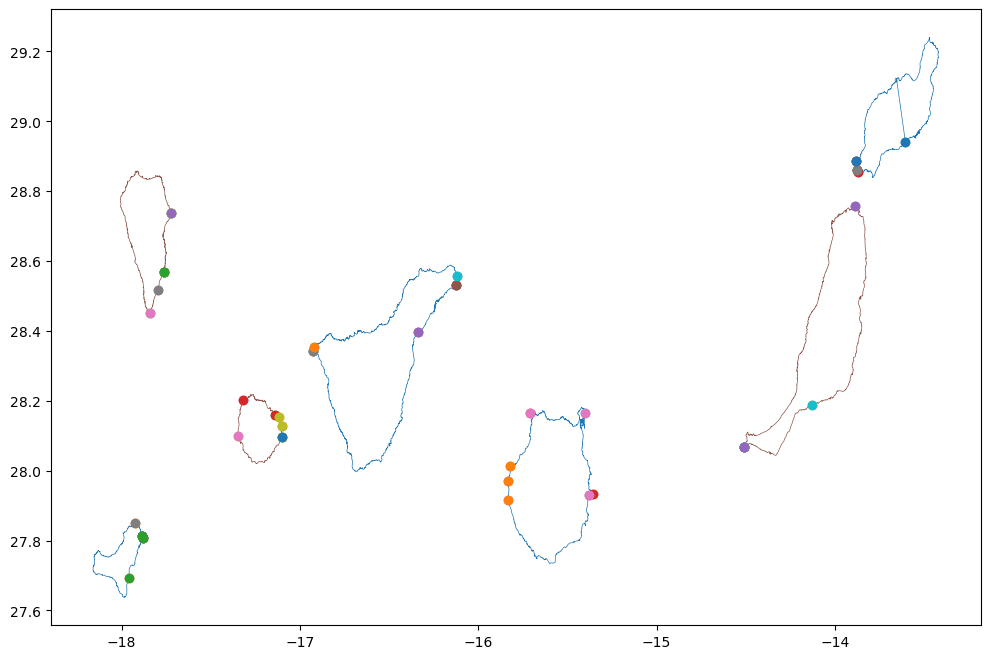

In [52]:
if isfile(distancefile)
    rm(distancefile)
end
df = open(distancefile, "w")

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

for ifile in 1:nfiles
    # Read coordinates from 1st file
    lon1, lat1, contour1 = read_largest_contour(datafilelist[ifile])
    #lon1, lat1, contour1 = read_coords(datafilelist[ifile])
    islandname1 = split(basename(datafilelist[ifile]), ".")[1]
    ax.plot(lon1, lat1, linewidth=.5)
    
    # Loop on the other files
    for ifile2 in 1:nfiles
        
        # Read 2nd island
        islandname2 = split(basename(datafilelist[ifile2]), ".")[1]
        lon2, lat2, contour2 = read_largest_contour(datafilelist[ifile2])
        #lon2, lat2, contour2 = read_coords(datafilelist[ifile2])

        # Compute min distance
        cp1, cp2, mindist = compute_min_dist(contour1, contour2)
        plt.plot(cp1[2], cp1[1], "o")
        plt.plot(cp2[2], cp2[1], "o")
        @debug("$(islandname1) -- $(islandname2)")
        @debug("Shortest distance: $(round(mindist, digits=1)) km")

        # Compute distance between summits
        dsummit = haversine(reverse(summits[islandname2]), reverse(summits[islandname1])) / 1000.
        @debug("Distance between summits: $(round(dsummit, digits=1)) km")
        
        # Write to file
        write(df, "$(islandname1), $(islandname2), $(cp1[1]), $(cp1[2]), $(cp2[1]), $(cp2[2]), $(mindist)\n")

    end
    
end
close(df)

plt.show()

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

for ifile in 1:nfiles
    # Read coordinates from 1st file
    lon1, lat1, contour1 = read_largest_contour_hr(datafilelist[ifile])
    islandname1 = split(basename(datafilelist[ifile]), ".")[1]
    ax.plot(lon1, lat1, linewidth=.5)
    plt.plot(summits[islandname1][2], summits[islandname1][1], "o")
    
    # Loop on the other files
    for ifile2 in 1:nfiles
        
        # Read 2nd island
        islandname2 = split(basename(datafilelist[ifile2]), ".")[1]
        lon2, lat2, contour2 = read_largest_contour_hr(datafilelist[ifile2])
        
   
        # Compute distance between summits
        dsummit = haversine(reverse(summits[islandname2]), reverse(summits[islandname1])) / 1000.
        @info("$(islandname1) -- $(islandname2): Distance between summits: $(round(dsummit, digits=1)) km")

        
    end
    
end

plt.show()

[ Info: nislands = 275


LoadError: InterruptException: